In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing required library for notebook

In [ ]:
from bs4 import BeautifulSoup
from collections import Counter,defaultdict
from gensim.models import Word2Vec,KeyedVectors
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import re
import gc
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.manifold import TSNE
import string
from unidecode import unidecode
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

## EDA(Explodatory Data Analysis)

Attribute Description:
1. Title - the title of the GitHub bug <br> 
1. Body - the body of the GitHub bug <br> 
1. Label - Represents various classes of Labels <br> 
 - Bug - 0 <br> 
 - Feature - 1 <br> 
 - Question - 2 <br> 

In [ ]:
train_df= pd.read_json("/kaggle/input/github-bugs-prediction/embold_train.json").reset_index(drop=True)
train_df.head()

In [ ]:
test_df= pd.read_json("/kaggle/input/github-bugs-prediction/embold_test.json").reset_index(drop=True)
test_df.head()

In [ ]:
train_ex_df= pd.read_json("/kaggle/input/github-bugs-prediction/embold_train_extra.json").reset_index(drop=True)
train_ex_df.head()

Looks like both the train and train extra dataframe contains the same content so let's combine them using concatenation command of pandas on index axis

Let's check the length of each dataframe

In [ ]:
def length_check(df):
    print(len(df),df.index.shape[-1])
                 
length_check(train_df)
length_check(train_ex_df)
length_check(test_df)

In [ ]:
mas_train_df = pd.concat([train_df,train_ex_df],ignore_index=True)
mas_train_df.head()

In [ ]:
length_check(mas_train_df)

In [ ]:
mas_train_df.info()

Let's drop duplicate if exists no duplicates exists <br>
No duplicates present in training dataset after combining

In [ ]:
mas_train_df.drop_duplicates(keep='first').count()

In [ ]:
mas_train_df.label.unique()

In [ ]:
label_0=train_df[mas_train_df['label']==0]['title']
label_1=train_df[mas_train_df['label']==1]['title']
label_2=train_df[mas_train_df['label']==2]['title']
print("First 10 samples of label 1 title\n".format(),label_0[:10])
print("First 10 samples of label 1 title\n".format(),label_1[:10])
print("First 10 samples of label 1 title\n".format(),label_2[:10])

### Count plot analysis
Lable 0 and 1 seems to be equal proportion. <br>
Lable 2 seems to be in less proportion

In [ ]:
print('Total Counts of label column: \n'.format(),mas_train_df['label'].value_counts())

sns.countplot(x='label', data=mas_train_df)

As we can see, all rows have a title and body. let's combine title and body because both seems to be containing relative text related to label

In [ ]:
def fx(x):
    return x['title'] + " " + x['body']   
mas_train_df['text']= mas_train_df.apply(lambda x : fx(x),axis=1)
test_df['text']= test_df.apply(lambda x : fx(x),axis=1)

In [ ]:
mas_train_df.head()

### Word Count Analysis
- Analyse the count of words in each label type segment
- Majority of the document/sentence contains only total word around 100-150
- Few of sentence word count is exceeded by 200 may be because of stopword, puntuation mark, url links etc.
- Which implies that lot of text cleaning needs to performed

In [ ]:
def cal_len(data):
    return len(data)

#Create generic plotter with Seaborn
def plot_count(count_zeros,count_ones,count_second,title_0,title_1,title_2,subtitle):
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_0)
    sns.distplot(count_ones,ax=ax2,color='Red')
    ax2.set_title(title_1)
    sns.distplot(count_second,ax=ax3,color='Green')
    ax3.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


label_0_words=mas_train_df[mas_train_df['label']==0]['text'].str.split().apply(lambda z:cal_len(z))
label_1_words=mas_train_df[mas_train_df['label']==1]['text'].str.split().apply(lambda z:cal_len(z))
label_2_words=mas_train_df[mas_train_df['label']==2]['text'].str.split().apply(lambda z:cal_len(z))
print("Label 0 Words:" + str(label_0_words))
print("Label 1 Words:" + str(label_1_words))
print("Label 2 Words:" + str(label_2_words))
plot_count(label_0_words,label_1_words,label_2_words,"Label 0 text","Label 1 text","Label 2 text","Reviews Word Analysis")

In [ ]:
label_0_df = mas_train_df[mas_train_df['label']==0]
label_1_df = mas_train_df[mas_train_df['label']==1]
label_2_df = mas_train_df[mas_train_df['label']==2]

- Lable 0 and Lable 2 contains many of the puntuation marks

In [ ]:
#Count Punctuations/Stopwords/Codes and other semantic datatypes
#We will be using the "generic_plotter" function.

count_0_punct=label_0_df['text'].apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
count_1_punct=label_1_df['text'].apply(lambda z:len([c for c in str(z) if c in string.punctuation]))
count_2_punct=label_2_df['text'].apply(lambda z:len([c for c in str(z) if c in string.punctuation]))
plot_count(count_0_punct,count_1_punct,count_2_punct,"Label 0 Punctuations","Label 1 Punctuations","Label 2 Punctuation", "Punctuation Analysis")

In [ ]:
del count_0_punct
gc.collect()
del count_1_punct
gc.collect()
del count_2_punct
gc.collect()

In [ ]:
stops=set(stopwords.words('english'))
count_0_stops=label_0_df['text'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
count_1_stops=label_1_df['text'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
count_2_stops=label_2_df['text'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
plot_count(count_0_stops,count_1_stops,count_2_stops,"Label 0 Stopwords","Label 1 Stopwords",'Label 2 Stopwords',"Text Stopwords Analysis")

### Word Cloud
- Word cloud is “an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.” So, the more often a specific words appears in your text, the bigger and bolder it appears in your word cloud
- A word cloud is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.<br>

In [ ]:
def draws_Word_Cloud(data):
    wordCloud=WordCloud(width=1000,height=700,stopwords = STOPWORDS).generate(' '.join(data))
    plt.figure(figsize = (15,8))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()

In [ ]:
draws_Word_Cloud(label_0_df['text'])

In [ ]:
draws_Word_Cloud(label_1_df['text'])

In [ ]:
draws_Word_Cloud(label_2_df['text'])

In [ ]:
def word_count_plot(df):
    c1= Counter()    
    for x in df['text']:
        c1.update(x.split())
    most=c1.most_common()
    x=[]
    y=[]
    for word,count in most[:50]:
        if (word not in stops) :
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)
    plt.show()

In [ ]:
word_count_plot(label_0_df)

In [ ]:
word_count_plot(label_1_df)

In [ ]:
word_count_plot(label_2_df)

**Insite From above Analysis**
* The dataset is balanced looks to be balanced for lable 0 and lable 1. lable 2 are comparatively less in number.<br>
* The dataset contains redundant words and html syntaxes.
* lot of Punctuations/stopwords are present in the dataset.

* Gram analysis on Training set- Bigram and Trigram

In [ ]:
extra_punctuations = ['','.', '``', '...', '\'s', '--', '-', 'n\'t', '_', '–','&']
stopword_list = stopwords.words('english') + list(string.punctuation)+ extra_punctuations + ['the','us','say','that','he','me','she','get','rt','it','mt','via','not','and','let','so','say','dont','use','you']

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
tokenizer=TweetTokenizer()

In [ ]:
def gram_analysis(data,gram):
    token= tokenizer.tokenize(data.lower()) 
    token = [tok for tok in token if len(tok) > 2 if tok not in stopword_list and not tok.isdigit()]
    ngrams=zip(*[token[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

In [ ]:
def create_dict(data,grams):
    freq_dict=defaultdict(int)
    for sentence in data:
        for tokens in gram_analysis(sentence,grams):
            freq_dict[tokens]+=1
    return freq_dict

In [ ]:
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["n_gram_words"].values[::-1],
        x=df["n_gram_frequency"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [ ]:
def create_new_df(freq_dict,):
    freq_df=pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1])
    freq_df.columns=['n_gram_words','n_gram_frequency']
    trace=horizontal_bar_chart(freq_df[:20],'orange')
    return trace

In [ ]:
def plot_grams(df1,df2,df3):
    fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.1,
                          subplot_titles=["Frequent words of lable 0", 
                                          "Frequent words of lable 1",
                                          "Frequent words of lable 2"])
    fig.append_trace(df1, 1, 1)
    fig.append_trace(df2, 1, 2)
    fig.append_trace(df3, 1, 3)
    fig['layout'].update(height=800, width=1000, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')

In [ ]:
for i in [2,3,5]:
    if(i==2):
        print("Bi-gram analysis")
    elif(i==3):
        print("Tri-gram analysis")
    else:
        print("Penta-gram analysis")
    freq_label_0_zero=create_dict(label_0_df['text'][:400],i)
    trace_zero=create_new_df(freq_label_0_zero)
    freq_label_1_ones=create_dict(label_1_df['text'][:400],i)
    trace_ones=create_new_df(freq_label_1_ones)
    freq_label_2_ones=create_dict(label_2_df['text'][:400],i)
    trace_secs=create_new_df(freq_label_2_ones)
    plot_grams(trace_zero,trace_ones,trace_secs)

In [ ]:
del label_0_df
gc.collect()
del label_1_df
gc.collect()
del label_2_df
gc.collect()

### Inference from ngram analysis <br>

* In this section, we have analysed based on lable features of words in a sentence. The Gram analysis,particularly the tirgram and pentagram analysis provides an idea set of words occur more often in the corpus.

* The above plot give a idea related to the frequency of the conjuction of words which are occuring at the highest frequency. Another important aspect is that,there is a presence of html tags, urls, dates and punctuations which should removed as these are adding noise to the lable corpus. This will be nect step.

## Text Cleaning
let us clean the dataset and remove the redundancies.This includes

1. HTML codes
1. URLs
1. Emojis
1. Stopwords
1. Punctuations
1. Expanding Abbreviations

In [ ]:
cList = {
            "i'm": "i am",
            "you're": "you are",
            "it's": "it is",
            "we're": "we are",
            "we'll": "we will",
            "That's":"that is",
            "haven't":"have not",
            "let's":"let us",
            "ain't": "am not / are not / is not / has not / have not",
            "aren't": "are not / am not",
            "can't": "cannot",
            "can't've": "cannot have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he had / he would",
            "he'd've": "he would have",
            "he'll": "he shall / he will",
            "he'll've": "he shall have / he will have",
            "he's": "he has / he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how has / how is / how does",
            "I'd": "I had / I would",
            "I'd've": "I would have",
            "I'll": "I shall / I will",
            "I'll've": "I shall have / I will have",
            "I'm": "I am",
            "I've": "I have",
            "isn't": "is not",
            "it'd": "it had / it would",
            "it'd've": "it would have",
            "it'll": "it shall / it will",
            "it'll've": "it shall have / it will have",
            "it's": "it has / it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she had / she would",
            "she'd've": "she would have",
            "she'll": "she shall / she will",
            "she'll've": "she shall have / she will have",
            "she's": "she has / she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as / so is",
            "that'd": "that would / that had",
            "that'd've": "that would have",
            "that's": "that has / that is",
            "there'd": "there had / there would",
            "there'd've": "there would have",
            "there's": "there has / there is",
            "they'd": "they had / they would",
            "they'd've": "they would have",
            "they'll": "they shall / they will",
            "they'll've": "they shall have / they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we had / we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what shall / what will",
            "what'll've": "what shall have / what will have",
            "what're": "what are",
            "what's": "what has / what is",
            "what've": "what have",
            "when's": "when has / when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where has / where is",
            "where've": "where have",
            "who'll": "who shall / who will",
            "who'll've": "who shall have / who will have",
            "who's": "who has / who is",
            "who've": "who have",
            "why's": "why has / why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you had / you would",
            "you'd've": "you would have",
            "you'll": "you shall / you will",
            "you'll've": "you shall have / you will have",
            "you're": "you are",
            "you've": "you have"
           }

In [ ]:
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

In [ ]:
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [ ]:
def remove_emoji(string):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string) 

In [ ]:
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

In [ ]:
def removeSpecialChars(data):
    '''
    Removes special characters which are specifically found in tweets.
    '''
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(data, "html.parser")
    data = soup.get_text()

    #Convert www.* or https?://* to empty strings
    data = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',data)

    #Convert @username to empty strings
    data = re.sub('@[^\s]+','',data)
    
    #remove org.apache. like texts
    data =  re.sub('(\w+\.){2,}','',data)

    #Remove additional white spaces
    data = re.sub('[\s]+', ' ', data)
    
    data = re.sub('\.(?!$)', '', data)

    #Replace #word with word
    data = re.sub(r'#([^\s]+)', r'\1', data)

    return data 

In [ ]:
def remove_nonenglish_charac(string):
    return re.sub('\W+','', string )

In [ ]:
def clean_text(data):
    data = unidecode(data)
    data = expandContractions(data)
    tokens = tokenizer.tokenize(data)
    data = ' '.join([tok for tok in tokens if len(tok) > 2 if tok not in stopword_list and not tok.isdigit()])
    data = re.sub('\b\w{,2}\b', '', data)
    data = re.sub(' +', ' ', data)
    data = removeSpecialChars(data)
    data = remove_emoji(data)
    data= [stemmer.stem(w) for w in data.split()]
    return ' '.join([wordnet_lemmatizer.lemmatize(word) for word in data])

In [ ]:
mas_train_df['text'].head()

In [ ]:
mas_train_df['text']=mas_train_df['text'].apply(lambda x: clean_text(x))

In [ ]:
mas_train_df['text'].head()

## Gram statistics after data cleaning
- Many of the url's links other than http or www are also removed after cleaning the text
- also many of the existing contraction has been expanded and exists in stop word those are also removed
- many non menaingful digits are also removed

In [ ]:
train_df_zero=mas_train_df[mas_train_df['label']==0]['text']
train_df_ones=mas_train_df[mas_train_df['label']==1]['text']
train_df_twos=mas_train_df[mas_train_df['label']==2]['text']

In [ ]:
for i in [2,3,5]:
    if(i==2):
        print("Bi-gram analysis")
    elif(i==3):
        print("Tri-gram analysis")
    else:
        print("Penta-gram analysis")
    freq_label_0_zero=create_dict(train_df_zero[:400],i)
    trace_zero=create_new_df(freq_label_0_zero)
    freq_label_1_ones=create_dict(train_df_ones[:400],i)
    trace_ones=create_new_df(freq_label_1_ones)
    freq_label_2_ones=create_dict(train_df_twos[:400],i)
    trace_secs=create_new_df(freq_label_2_ones)
    plot_grams(trace_zero,trace_ones,trace_secs)

In [ ]:
draws_Word_Cloud(train_df_zero)

In [ ]:
draws_Word_Cloud(train_df_ones)

In [ ]:

draws_Word_Cloud(train_df_twos)

## Summary
- text cleaning is completed after removing punctuatuon, html tag, urls, stop words and alphanumeric characters.
- as more of the noisy data has been removed we can peform other semantics analysis

## Vectorization and Embeddings
In this context, we will be vectorizing our dataset. This would allow us to convert our data to higher dimensional containers (matrices). These vectorization strategies allow the word corpus to be properly suitable for advanced semantic analysis.

Here there are 2 variants of transforming the textual corpus to a numerical vector:

Vectorize without semantics
Retain Semantic Importance
In the first case, vectorization strategy is used to provide a co-occurence probabilistic distribution for vectorization. Methods like TF-IDF,Count vectorization/One hot vectorization, falls under this criteria.These methods leverage statistical co-occurence probabilities and log likelihoods for determining the frequently occuring sentences or group of words in a corpus.

The second case, relies on applying vectors with respect to semantic importance. Embeddings fall under this category. Embeddings are largely of 2 kinds

Static Embeddings: Word2Vec, Glove, Fasttext, Paragram
Dynamic Embeddings: ELMO, BERT & its variants, XLNet/Transformer-XL
All of these embeddings rely on pretrained word vectors where a probabilistic score is attributed to each word in the corpus. These probabilities are plotted in a low dimensional plane and the "meaning" of the words are inferred from these vectors. Generally speaking cosine distance is taken as the major metric of similarity measurement between word and sentence vectors to infer similarity.


We will move ahead with TFIDF and Count vectorization strategies and will be going in further sections.

TF-IDF Vectorization: This works by applying a logarithmic term to inverse document frequency (IDF) part other than determining the "TF" or term freqency part. The formulation can be shown as follows:
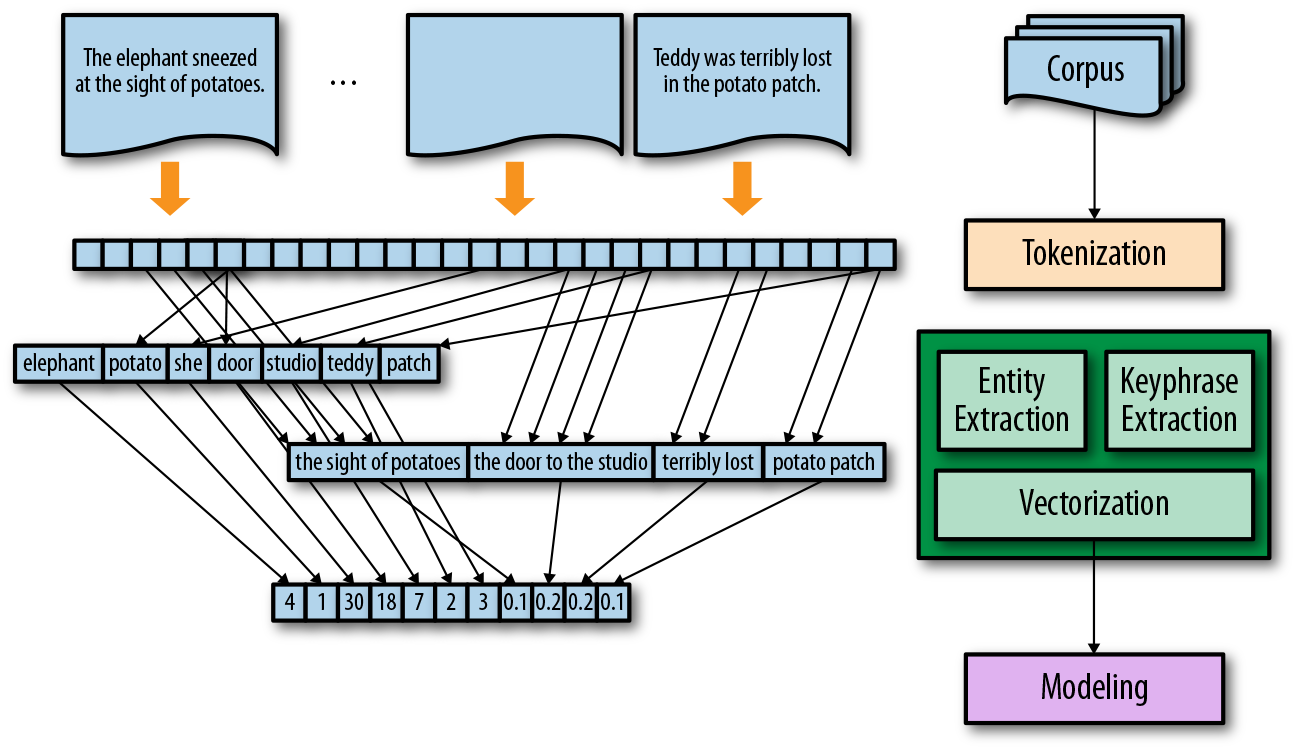


Count Vectorization: This is a simpler vectorization technique which relies on frequency of occurence of a particular term in a document or corpus.
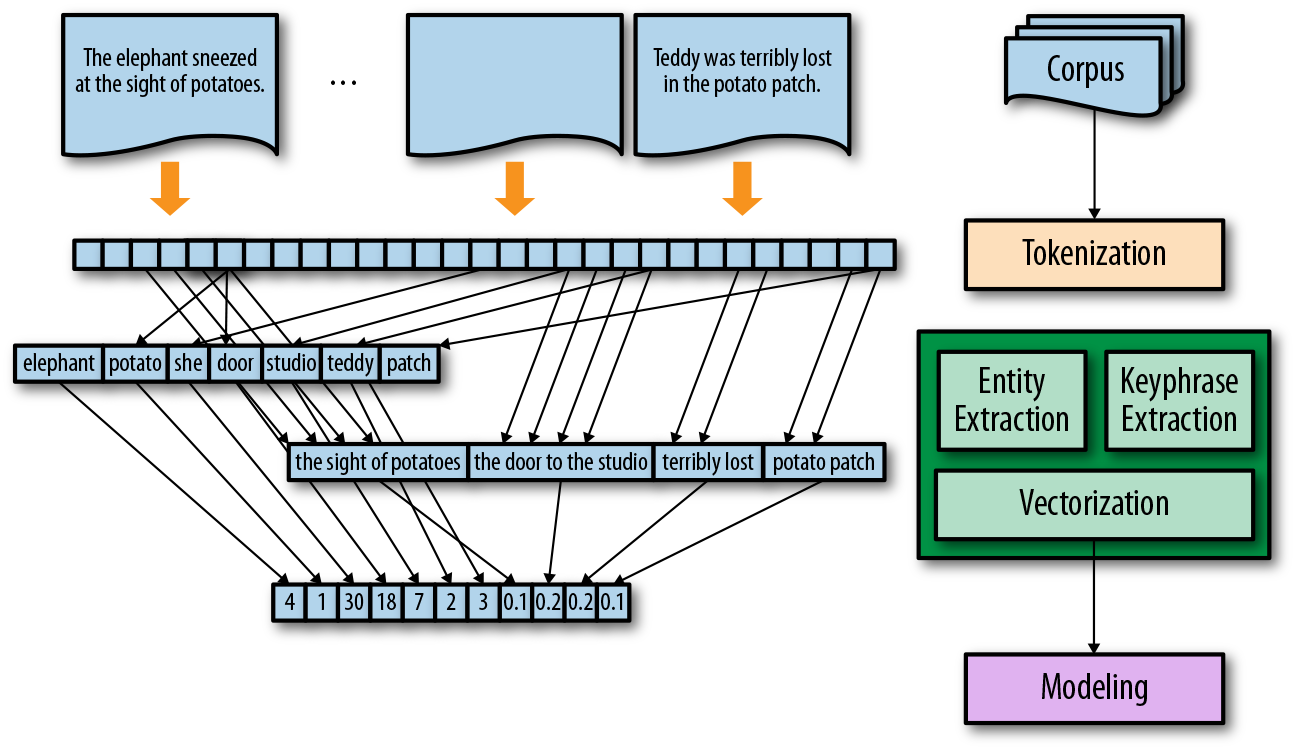

In [ ]:
tfidf_vect=TfidfVectorizer(stop_words='english',ngram_range=(1,3))
train_tfidf=tfidf_vect.fit_transform(mas_train_df['text'].values.tolist())
train_tfidf.shape

## Visualizing the Vector Space

The curse of dimensionality occurs because the sample density decreases exponentially with the increase of the dimension. When we keep adding features without increasing the number of training samples as well, the dimensionality of the feature space grows and becomes sparser and sparser. Due to this sparsity, it becomes much easier to find a “perfect” solution for the machine learning model which highly likely leads to overfitting.
Dimensionality reduction is the process of reducing the dimensionality of the feature space with consideration by obtaining a set of principal features. Dimensionality reduction can be further broken into feature selection and feature extraction.
Feature selection tries to select a subset of the original features for use in the machine learning model. In this way, we could remove redundant and irrelevant features without incurring much loss of information.

Now, we have to reduce the dimensions ,else the kernel will run out of memory. For this we wmploy 3 different decomposition techniques:

PCA <br>
SVD <br>
TSNE <br>

These algorithms rely on Eigen vector decomposition and Eigen matrices for creating smaller matrices. These reduced matrices are well-fitted to perform any numerical approximation tasks from differentiation to higher order non linear dynamics. PCA in general is a well known method and forms the base of all decomposition techniques. Pictorially it operates as follows with the help of orthogonal Eigen vectors:
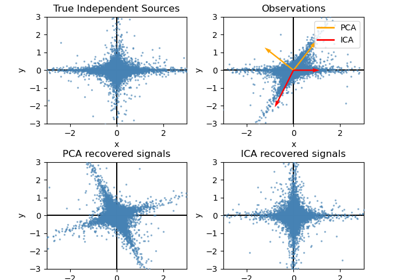

TSNE is a more sophisticated method which uses a non convex optimization along with gradient descent. This is different than Eigen Vector (convex optimization) method of PCA and hence different results may be obtained in different iterations. It is a memory intensive method and is often powerful at the expense of longer execution time.
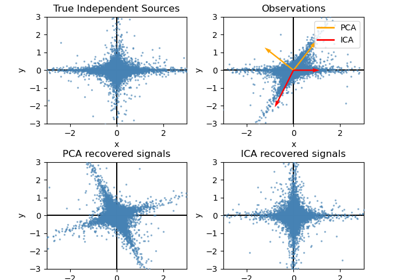

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

In [ ]:
def count_vectorize(data):
    cv=CountVectorizer()
    fit_data_cv=cv.fit_transform(data)
    return fit_data_cv,cv

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

In [ ]:
#Tfidf vectorization from sklearn
def tfidf(data):
    tfidfv=TfidfVectorizer()
    fit_data_tfidf=tfidfv.fit_transform(data)
    return fit_data_tfidf,tfidfv

In [ ]:
def dimen_reduc_plot(test_data,test_label,option):
    tsvd= TruncatedSVD(n_components=2,algorithm="randomized",random_state=42)
    tsne=TSNE(n_components=2,random_state=42) #not recommended instead use PCA
    pca=SparsePCA(n_components=2,random_state=42)
    if(option==1):
        tsvd_result=tsvd.fit_transform(test_data)
        plt.figure(figsize=(10,8))
        colors=['orange','red','blue']
        
        sns.scatterplot(x=tsvd_result[:,0],y=tsvd_result[:,1],hue=test_label,
                        palette=['green','brown','dodgerblue'])
        
        plt.show()
        plt.figure(figsize=(10,10))
        plt.scatter(tsvd_result[:,0],tsvd_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Label 0')
        color_orange=mpatches.Patch(color='green',label='Label 1')
        color_blue=mpatches.Patch(color='blue',label='Label 2')
        plt.legend(handles=[color_orange,color_red,color_blue])
        plt.title("TSVD")
        plt.show()
    if(option==2):
        tsne_result=tsne.fit_transform(test_data)
        plt.figure(figsize=(10,8))
        colors=['orange','red','blue']
        sns.scatterplot(x=tsne_result[:,0],y=tsne_result[:,1],hue=test_label)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.scatter(x=tsne_result[:,0],y=tsne_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Label 0')
        color_orange=mpatches.Patch(color='green',label='Label 1')
        color_blue=mpatches.Patch(color='blue',label='Label 2')
        plt.legend(handles=[color_orange,color_red,color_blue])
        plt.title("PCA")
        plt.show() 
    if(option==3):
        pca_result=pca.fit_transform(test_data.toarray())
        plt.figure(figsize=(10,8))
        colors=['orange','red','blue']
        sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],hue=test_label)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.scatter(x=pca_result[:,0],y=pca_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Label 0')
        color_orange=mpatches.Patch(color='green',label='Label 1')
        color_blue=mpatches.Patch(color='blue',label='Label 2')
        plt.legend(handles=[color_orange,color_red,color_blue])
        plt.title("TSNE")
        plt.show()

In [ ]:
text_vect=mas_train_df['text'].values
target_vect=mas_train_df['label'].values
train_data_cv,cv= tfidf(text_vect)

In [ ]:
dimen_reduc_plot(train_data_cv,target_vect,1)

In [ ]:
del_bj_list=[]

In [ ]:
#TSNE visualization on first 1000 samples
train_data=mas_train_df[:1000]
data_vect=train_data['text'].values
target_vect=train_data['label'].values
train_data_cv,cv= tfidf(data_vect)
dimen_reduc_plot(train_data_cv,target_vect,3)

In [ ]:
def multiple_appends(list1, *element):
    list1.extend(element)

In [ ]:
multiple_appends(del_bj_list,train_data,data_vect,target_vect,train_data_cv,cv,text_vect)

In [ ]:
for obj in del_bj_list:
    del obj
    gc.collect()

> ## Word Embedding
* Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation.
* Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network

# Word2Vec
* Word2Vec is a statistical method for efficiently learning a standalone word embedding from a text corpus.Word2Vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets.

* Two different learning models were introduced that can be used as part of the word2vec approach to learn the word embedding; they are:

1. Continuous Bag-of-Words, or CBOW model.
1. Continuous Skip-Gram Model.
The CBOW model learns the embedding by predicting the current word based on its context. The continuous skip-gram model learns by predicting the surrounding words given a current word.
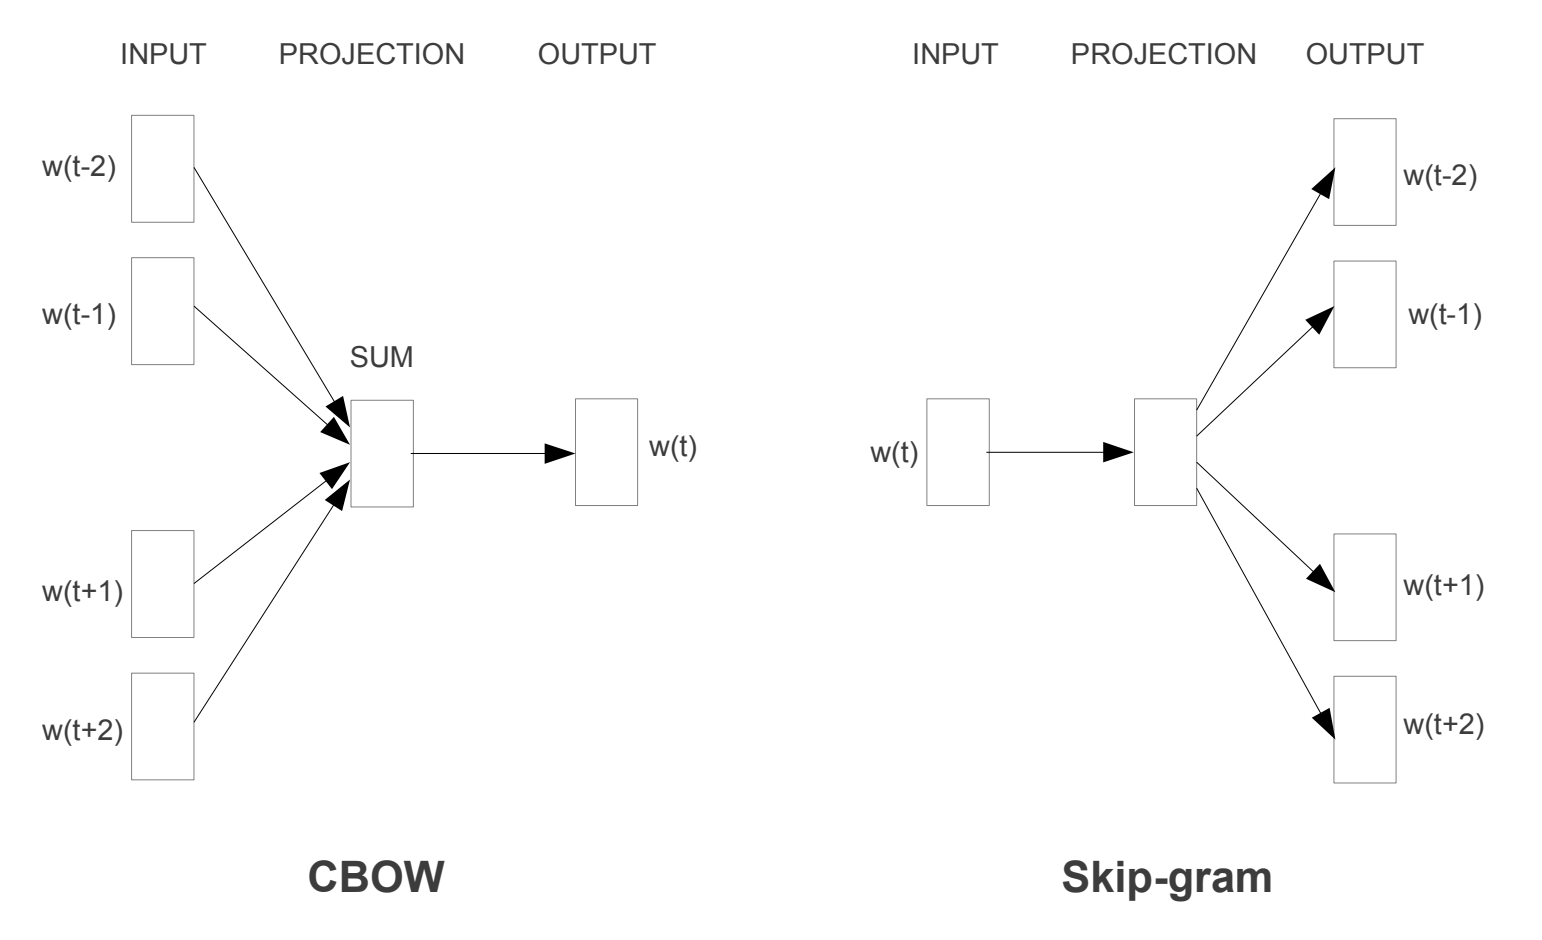

The size of the sliding window has a strong effect on the resulting vector similarities. Large windows tend to produce more topical similarities […], while smaller windows tend to produce more functional and syntactic similarities.

In [ ]:
check_df=list(mas_train_df['text'].str.split())

In [ ]:
import multiprocessing
# Count the number of cores in a computer
cores = multiprocessing.cpu_count() 

## The parameters:
There are many parameters on this constructor; a few noteworthy arguments you may wish to configure are:

* size: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).<br>
* window: (default 5) The maximum distance between a target word and words around the target word.<br>
* min_count: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
* workers: (default 3) The number of threads to use while training.<br>
* sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).<br>

Let's check with CBOW or skip-gram which gives better result

In [ ]:
model=Word2Vec(check_df,window=2,workers=cores-1,sg=0)
word_li=list(model.wv.vocab)
print(word_li[:10])

In [ ]:
model_skpgra=Word2Vec(check_df,window=2,workers=cores-1,sg=1)
word_li_skp_Gram=list(model_skpgra.wv.vocab)
print(word_li_skp_Gram[:20])

In [ ]:
plt.plot(model['piano'])
plt.plot(model_skpgra['piano'])
plt.show()

In [ ]:
del model_skpgra
gc.collect()

In [ ]:
model.save('word2vec_model.bin')
loaded_model=KeyedVectors.load('word2vec_model.bin')

In [ ]:
def TSNE_SCatterPlot(word_model):
    tsne = TSNE(n_components=2)
    transformation_model=word_model[word_model.wv.vocab]
    result = tsne.fit_transform(transformation_model[:50])
    df = pd.DataFrame(result, index=word_li[:50], columns=['x', 'y'])
    plt.scatter(df['x'], df['y'])
    for word, pos in df.iterrows(): 
        plt.annotate(word, pos)
    plt.figure(figsize=(20,10))
    plt.show()

In [ ]:
TSNE_SCatterPlot(model)

In [ ]:
distance=model.similarity('state','alarm')
print(distance)

In [ ]:
google_news_embed='../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
google_loaded_model=KeyedVectors.load_word2vec_format(google_news_embed,binary=True)

In [ ]:
plt.plot(google_loaded_model['action'])
plt.show()

In [ ]:
TSNE_SCatterPlot(google_loaded_model)

In [ ]:
del google_loaded_model
gc.collect()
del check_df
gc.collect()
del model
gc.collect()

## Types of Word2Vec algorithms
These variants include :

*FastText <br>
*[Glove](https://nlp.stanford.edu/projects/glove/)<br>
*[Google News Vectors](https://code.google.com/archive/p/word2vec/)

## Glove Embeddings

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_file='../input/glove6b50dtxt/glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove_loaded=glove2word2vec(glove_file, word2vec_output_file)
print(glove_loaded)

In [ ]:
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
plt.plot(glove_model['action'])
plt.plot(glove_model['alarm'])
plt.show()

In [ ]:
TSNE_SCatterPlot(glove_model)

In [ ]:
del glove_model
gc.collect()

## Fast text Embedding
- FastText as a library for efficient learning of word representations and sentence classification. It is written in C++ and supports multiprocessing during training. The model allows one to create an unsupervised learning or supervised learning algorithm for obtaining vector representations for words
- FastText supports training continuous bag of words (CBOW) or Skip-gram models using negative sampling, softmax or hierarchical softmax loss functions. 
- FastText is able to achieve really good performance for word representations and sentence classification, specially in the case of rare words by making use of character level information.word2vec treats every single word as the smallest unit whose vector representation is to be found but FastText assumes a word to be formed by a n-grams of character
- Each word is represented as a bag of character n-grams in addition to the word itself, so for example, for the word matter, with n = 3, the fastText representations for the character n-grams is <ma, mat, att, tte, ter, er>. < and > are added as boundary symbols to distinguish the ngram of a word from a word itself
Pros and Cons of FastText
Like every library in development, it has its pros and cons. Let us state them explicitly.

### Pros
1. The library is surprisingly very fast in comparison to other methods for achieving the same accuracy. Here is the result published by the Facebook research team in support of the argument.Comparison of FastText with other Word Representation models
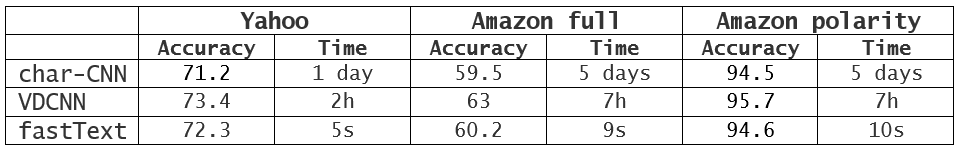
1. Sentence Vectors(supervised) can be easily computed.
1. fastText works better on small datasets in comparison to gensim.
1. fastText performs superior to gensim in terms of syntactic performance and fairs equally well in case of semantic performance. <br>

### Cons
1. This is not a standalone library for NLP since it will require another library for the pre-processing steps.
1. Though, this library has a python implementation. It is not officially supported.

In [ ]:
fasttext_file="../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_file, binary=False)
plt.plot(fasttext_model['action'])
plt.plot(fasttext_model['alarm'])
plt.show()

In [ ]:
TSNE_SCatterPlot(fasttext_model)

In [ ]:
del fasttext_model
gc.collect()

## Matrix Embdedding using deep learning algorithm

In [ ]:
maxlen=1000
max_features=5000
embed_size=300
text_df = mas_train_df['text']

In [ ]:
def getMaxLengthSentence(corp):
    maxlen=-1
    for doc in corp:
        tokens=nltk.word_tokenize(doc)        
        if(maxlen<len(tokens)):
            maxlen=len(tokens)
    print("The maximum number of words in any document is : ",maxlen)

In [ ]:
#getMaxLengthSentence(text_df)

## PADDING THE DOCS (to make very doc of same length)
- The Keras Embedding layer requires all individual documents to be of same length. Hence we wil pad the shorter documents with 0 for now. Therefore now in Keras Embedding layer the 'input_length' will be equal to the length (ie no of words) of the document with maximum length or maximum number of words.
- to create embeddings all of our docs need to be of same length. hence we can pad the docs with zeros.

In [ ]:
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(text_df))
train_sample=tokenizer.texts_to_sequences(text_df)

#Pad the sequence- To allow same length for all vectorized words
train_sample=pad_sequences(train_sample,maxlen=maxlen)

Now all the documents are of same length (after padding). And so now we are ready to create and use the embeddings.

# Embdedding work flow
- Create the dictionary of pretrained embedding with respective decimal array values if length of embedded word is greater thatn zero
- using numpy stack function prepared multidimentional dictionary
- using word embedding creating distribution of any type like gaussian/bernouli/poisson for increasing model accuracy
-

In [ ]:
# Create the dictionary of pretrained embedding
EMBEDDING_FILE = '../input/wikinews300d1msubwordvec/wiki-news-300d-1M-subword.vec'
def get_embedding_dict(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_embedding_dict(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

# prepared multidimentional dictionary
all_embs = np.stack(embeddings_index.values())

In [ ]:
# prepare a gausiian distribution
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

In [ ]:
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
plt.plot(embedding_matrix[20])
plt.show()